In [1]:
# %load main.py
import sys

import numpy as np
import datetime as dt

from armax import armax
from config import config
import mysql_utils as mysql
import visualization

In [2]:
#DETECTOR_DATA_TABLE = "detector_data_processed_2017_1"
DETECTOR_DATA_TABLE = "detector_data_processed_2017"
DETECTOR_ID = "608219"
DETECTOR_DATA_QUERY = "SELECT DetectorID, Year, Month, Day, Time, Volume, Occupancy\
                        FROM {} AS DD NATURAL JOIN detector_health AS DH\
                        WHERE DetectorID = {} AND Health = 1\
                        ORDER BY Year, Month, Day, Time;".format(DETECTOR_DATA_TABLE, DETECTOR_ID)

In [3]:
def query_detector_data(cursor, table, detector_id, graph=False):
    query = DETECTOR_DATA_QUERY.format(table, detector_id)

    cursor = mysql.query(cursor, query)
    
    if cursor == None:
        return

    time = []
    volume = []
    occupancy = []
    #speed = []

    for row in cursor:
        d = dt.datetime(row[1], row[2], row[3], row[4] // 3600, (row[4] % 3600) // 60, row[4] % 60)
        time.append(d)

        volume.append(row[5])
        occupancy.append(row[6])
        #speed.append(row[7])

    time = np.array(time)
    volume = np.array(volume)
    occupancy = np.array(occupancy)
    occupancy_percentage = occupancy / 3600 * 100
    #speed = np.array(speed)

    if graph:
        visualization.plot_data_over_time(time, volume, title="Detector {} Volume January 2017".format(detector_id), ylabel="Volume (vph)", figsize=(12, 5))
        visualization.plot_data_over_time(time, occupancy, title="Detector {} Occupancy January 2017".format(detector_id), ylabel="Occupancy (s)", figsize=(12, 5))
        #visualization.plot_data_over_time(time, speed, title="Detector {} Speed January 2017".format(detector_id), ylabel="Speed", figsize=(12, 5))
        visualization.plot_data_over_time(time, occupancy_percentage, title="Detector {} Occupancy January 2017".format(detector_id), ylabel="Occupancy (%)", figsize=(12, 5))
        visualization.plot_fundamental_diagram(volume, occupancy_percentage, title="Detector {} Flow-Occupancy Diagram January 2017".format(detector_id))

    return time, volume, occupancy

In [4]:
cnx = mysql.connect_to_database(**config)

if cnx == None:
    sys.exit()

cursor = cnx.cursor()

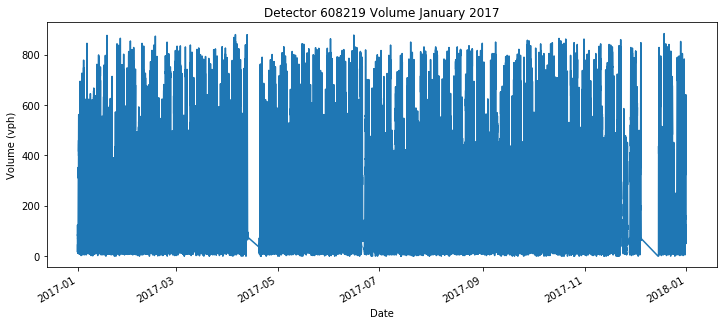

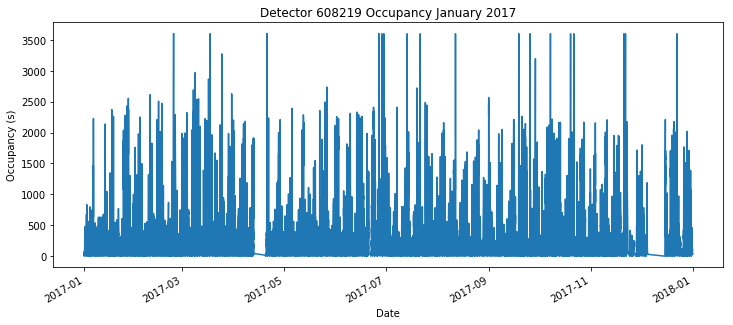

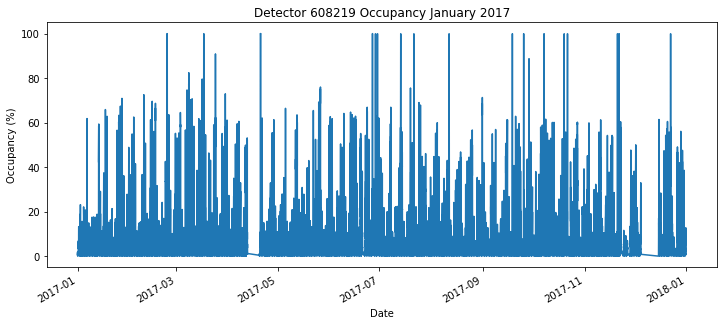

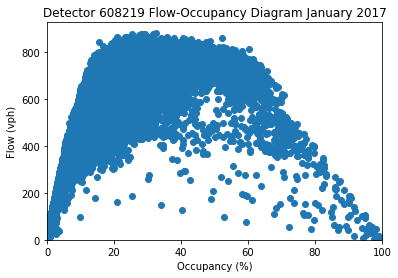

In [5]:
time, flow, occupancy = query_detector_data(cursor, DETECTOR_DATA_TABLE, DETECTOR_ID, graph=True)

In [6]:
armax_model = armax(flow, dates=time)

In [7]:
armax_model.fit(verbose=True)

Fitting order (1, 1)
Order (1, 1) aic: 879931.5444531591
Fitting order (1, 2)
Order (1, 2) aic: 872123.7335391992
Fitting order (1, 3)
Order (1, 3) aic: 866887.7481680567
Fitting order (2, 1)
Order (2, 1) aic: 875410.238440533
Fitting order (2, 2)
Order (2, 2) aic: 867858.9282041069
Fitting order (2, 3)
Order (2, 3) aic: 865943.3309382248
Fitting order (3, 1)
Order (3, 1) aic: 863947.1473889977
Fitting order (3, 2)
Order (3, 2) aic: 862455.5812832013
Fitting order (3, 3)
Order (3, 3) aic: 862255.5811382801
Done fitting ARMA model; best order: (3, 3)


In [8]:
print(armax_model.best_model_order)

(3, 3)


In [ ]:
cursor.close()
cnx.close()